## Train a CBOW word vectors model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import csv
csv.field_size_limit(100000000)

import glob
import os
import sys

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from toolz.functoolz import compose

In [7]:
os.environ['CRANIAL_LOGLEVEL'] = "INFO"
from cranial.re_iter import ReMap, ReChain, ReFilter, Progress, ReBatch, DiskCache, ReZip
from cranial.models.tokenizers import MosesTokenizer
from cranial.models.gensim_models import GensimDictionary
from cranial.model_base import StatefulModel

## Define files list

In [8]:
files = glob.glob('data/*.csv')

with open(files[0]) as f:
    print(f.readline().strip().split(','))

['', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']


#### Helper function that returns generator of parsed lines from a file

In [9]:
def read_csv(fname):
    with open(fname) as f:
        reader = csv.reader(f)
        header = next(reader)
        for line in reader:
            yield dict(zip(header, line))

## Instantiate objects and define tranformations pipeline

In [10]:
# this will create a pathos process pool with size 4 and is it to process individual items
mt = MosesTokenizer('path_to_/mosesdecoder/', proc_type='sub', n_proc=4)

In [11]:
# file name -> generator of lines (records)
out = ReMap(read_csv, files)

# chain together all records from all generators
records = ReChain(out, name='chain rows from files')

# record -> text
out = ReMap(lambda rec: rec['content'].lower(), records)

# create batches of texts, join them all into single string with 4x new lines separators
out = ReBatch(out, batch_size=2000)
out = ReMap(lambda batch: '\n\n\n\n'.join(batch), out)

# use moses tokenizer wrapper to convert text into a string where all tokens are separated by space
out = mt.itransform(out)

# split batched strings by 4x new lines and chain all results together
out = ReMap(lambda s: s.split('\n\n\n\n'), out)
out = ReChain(out)

# just print the number of processed texts so far
out = Progress(out, max_period=10000, name='OUT')

# store to disk intermediate results to avoid costly re-runs
out = DiskCache(out)

# text -> list of tokens
tokens = ReMap(lambda s: s.split(), out)

## Train a dictionary

Use gensim dictionary to control the size of the vocabulary and to convert tokens into integer IDs

In [12]:
gensim_dict = GensimDictionary({
    'no_below_raw': 0,
    'no_above_raw': 1.,
    'max_n_raw': 100000,
    'no_below': 10,
    'no_above': 1.,
    'max_n': 10000,
    'dict_filter_every': 50000,
})

gensim_dict = gensim_dict.train(tokens)

2018-07-03T08:49:06PDT - gensim_models.py - INFO - Init gensim dictionary with params:
{'no_below_raw': 0, 'no_above_raw': 1.0, 'max_n_raw': 100000, 'no_below': 10, 'no_above': 1.0, 'max_n': 10000, 'dict_filter_every': 50000}
2018-07-03T08:49:06PDT - gensim_models.py - INFO - Building gensim dictionary...
2018-07-03T08:49:06PDT - re_iter.py - INFO - reMap:	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - Disk Cache:	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - Disk Cache:	Saving iterable to 1bb3959f-7758-4d72-b7ea-6c0f127b8a4c
2018-07-03T08:49:06PDT - re_iter.py - INFO - OUT:	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - :	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - reMap:	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - MosesTokenizer sub:	Start iter number 1
2018-07-03T08:49:06PDT - re_iter.py - INFO - Trying to terminate previous pool
2018-07-03T08:49:06PDT - re_iter.py - WARNING - Is this th

### Define tranformation from tokens to IDs 

In [13]:
# ise gensim dictionary to convert tokens to IDs, 
# each item in the resulting iterator is an original 
# text document represented as a list of integers
ids = ReMap(lambda d: gensim_dict.state.model.doc2idx(d), tokens)

# prune to go through the dataset faster so can go through it more times
# this will improve randomization of training data
ids = ReFilter(lambda _: np.random.rand() > 0.9, ids)

# shiffle documents with buffer 20k
ids = ReBatch(ids, batch_size=1000, only_full=True, shuffle=True, buffer_size=20000)
ids = ReChain(ids)

### Define tranformations from tokenized documents to training examples

In [14]:
# set context window size (number of tokens on each side of a center token)
ws = 3

# make (context windows, center) pairs
pairs = ReMap(lambda l: [(l[i:i+ws] + l[i+ws+1:i+2*ws+1], l[i+ws]) for i in range(len(l) - 2*ws)], ids)
pairs = ReChain(pairs)

# shuffle examples with buffer 100k and assemble into batches
pairs = ReBatch(pairs, batch_size=256, only_full=True, shuffle=True, buffer_size=100000)

### Transform batches into pytorch tensors

In [ ]:
def collate_fn(batch):
    """Convert a batch of python lists of integers into pytorch tensors"""
    # shift all IDs by 1 to adjust for unknown words which have ID = -1 in gensim
    x = torch.LongTensor([pair[0] for pair in batch]) + 1 
    y = torch.LongTensor([pair[1] for pair in batch]) + 1
    return (x, y)

In [ ]:
batches = ReMap(collate_fn, pairs)

## Define pytorch model

In [15]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, embedding_dim, scale_grad_by_freq=True)
        self.lin = nn.Linear(embedding_dim, vocab_size)
        self.lin.weight = self.emb.weight

    def forward(self, x):
        out = self.emb(x)
        out = self.lin(out)
        out = F.log_softmax(out, dim=1)
        return out

### Instantiate and train

In [17]:
cbow = CBOW(len(gensim_dict.state.model)+1, 128)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(cbow.parameters(), lr=0.001)
losses = []

In [ ]:
for ep in range(5):
    for i, (x, y) in enumerate(Progress(batches, max_period=1000, name='batches')):
        optimizer.zero_grad()
        out = cbow(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            print(i, '\t', loss.item())

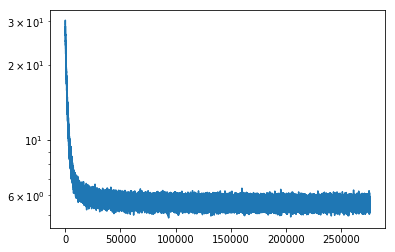

In [125]:
semilogy(losses)

## Do a little bit of words math

In [151]:
v1 = sum([cbow.emb.weight[gensim_dict.state.model.token2id[w] + 1] for w in 'washington'.split()])
v2 = sum([cbow.emb.weight[gensim_dict.state.model.token2id[w] + 1] for w in 'america'.split()])
v3 = sum([cbow.emb.weight[gensim_dict.state.model.token2id[w] + 1] for w in 'russia'.split()])

vq = v1 - v2 + v3

In [152]:
distances = torch.sum((cbow.emb.weight - vq)**2, dim=1)

In [153]:
ds, ixs = torch.sort(distances, 0)
for i, d, j in zip(range(15), ds, ixs):
    j = j.item()
    if j > 0:
        print(d, '\t', gensim_dict.state.model.id2token[j-1])

tensor(28.6929) 	 washington
tensor(32.9521) 	 moscow
tensor(33.3162) 	 post
tensor(35.9955) 	 russia
tensor(40.3321) 	 post.
tensor(40.5119) 	 sanctions
tensor(41.0595) 	 russian
tensor(41.3179) 	 c.
tensor(41.9050) 	 kislyak
tensor(43.6825) 	 sergey
tensor(44.4279) 	 russia.
tensor(44.6247) 	 tehran
tensor(44.7495) 	 d.
tensor(45.2658) 	 ambassador
tensor(46.1342) 	 diplomatic


Moscow in the second place - good enough.